# Run Zernike Estimation on AuxTel runs

Author: Bryce Kalmbach

Date: 02-02-2023

This notebook shows how to run the WEP pipeline on AuxTel data and save the output in the butler repository.

In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
%matplotlib inline

## Get AuxTel raw data

Get the latest AuxTel data found in `/repo/embargo`

In [2]:
repo_dir = '/repo/embargo/'

In [3]:
butler = Butler(repo_dir)

Find the exposures.

In [5]:
dataIds = list(butler.registry.queryDataIds(['exposure', 'detector'], collections='LATISS/raw/all', datasets='raw', instrument="LATISS", where='exposure.day_obs IN ( 20230201)'))

From the [night log for 2/1/2023](https://confluence.lsstcorp.org/display/LSSTCOM/2023-02-01+AuxTel+NightLog) we can see that first CWFS run had exposures 303-307. We try to get data from this set of images with 303 and 304.

In [4]:
butler = Butler('/repo/embargo/',
                          collections=['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook'])
datasetRefOrType='raw'
year='2023'
monthDay='0201'

exp_short_num_1 = '00303'
data_id_1 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_1}')}
exposure_1 =  butler.get(datasetRefOrType, dataId=data_id_1, )

exp_short_num_2 = '00304' 
data_id_2 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_2}')}
exposure_2 = butler.get(datasetRefOrType, dataId=data_id_2,)

camera = butler.get('camera', {'instrument': 'LATISS'})

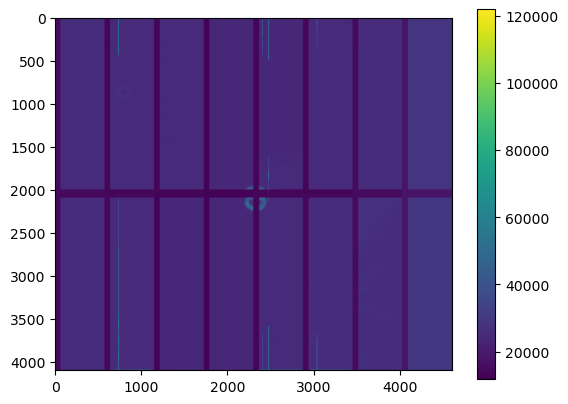

In [8]:
# Take a look at one of the images.
plt.imshow(exposure_1.image.array, )
plt.colorbar()

We have two images but we want to make sure we have a pair of intra-focal and extra-focal. Look at `visitInfo.focusZ` to find this info.

In [9]:
print(exposure_1.visitInfo.focusZ, exposure_2.visitInfo.focusZ)

0.800000011920929 -0.801099956035614


`exposure_1` has a positive `focusZ` values meaning it is the intra-focal image and `exposure_2` is the extra-focal image so we can use these two images in the WEP pipeline to estimate Zernikes.

## Run WEP pipeline and save output to butler

In [21]:
data_id_1, data_id_2

({'instrument': 'LATISS',
  'detector': 0,
  'exposure': 2023020100303,
  'visit': 2023020100303},
 {'instrument': 'LATISS',
  'detector': 0,
  'exposure': 2023020100304,
  'visit': 2023020100304})

In [27]:
# Set up information for pipeline
exposure_num_1 = data_id_1['exposure']
exposure_num_2 = data_id_2['exposure']
output_butler_run = 'u/brycek/DM-37838'
data_query = f"exposure in ({exposure_num_1}, {exposure_num_2})"

A possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection

In [30]:
! pipetask run -b $repo_dir -i LATISS/raw/all,LATISS/calib --instrument lsst.obs.lsst.Latiss --register-dataset-types --output-run $output_butler_run -p latissWepPipeline.yaml -d "$data_query"

lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1675444312.8282752-6880'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
py.warnings WARNING: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.1.0/Linux64/obs_base/gdadf9dca80+ee6e69aab3/python/lsst/obs/base/formatters/fitsExposure.py:643: UserWarning: Reading file:///tmp/tmp1hosl8iz.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'empty~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="white", physical="empty~empty")).  This is probably a bug in the code that produced it.
  warnings.warn(

lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Applying bias correction.
lsst.isr INFO: Masking defects.
l

In [32]:
data_id_1['visit'] = data_id_1['exposure']
data_id_2['visit'] = data_id_2['exposure']

In [33]:
data_id_intra = data_id_1
data_id_extra = data_id_2

### Look at output

In [34]:
# Reload butler to get new collection
butler = Butler(repo_dir)

In [35]:
list(butler.registry.queryDataIds(['exposure', 'visit', 'detector'], datasets='zernikeEstimateRaw', collections='u/brycek/DM-37838'))

[{instrument: 'LATISS', detector: 0, exposure: 2023020100304, visit: 2023020100304, ...}]

In [39]:
zernOut = butler.get('zernikeEstimateRaw', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [40]:
donutCatExtra = butler.get('donutCatalog', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [41]:
donutCatIntra = butler.get('donutCatalog', dataId=data_id_intra, collections='u/brycek/DM-37838')

In [42]:
postIsrExtra = butler.get('postISRCCD', dataId=data_id_extra, collections='u/brycek/DM-37838')
postIsrIntra = butler.get('postISRCCD', dataId=data_id_intra, collections='u/brycek/DM-37838')

Text(0, 0.5, 'Zernike Values (microns)')

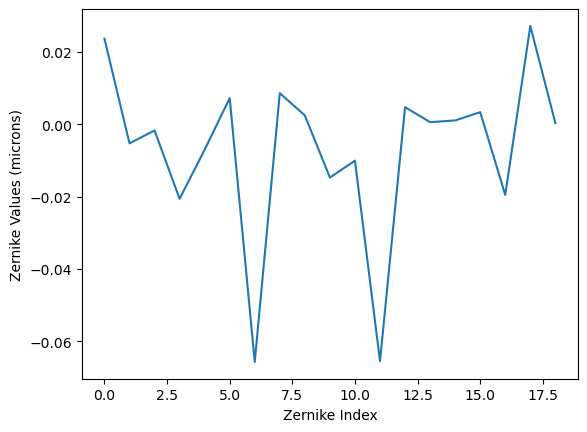

In [43]:
plt.plot(zernOut[0])
plt.xlabel('Zernike Index')
plt.ylabel('Zernike Values (microns)')

In [44]:
donutCatIntra

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,1.732556,-0.454114,2028.89696,2053.98171,RXX_S00,2.317241e+08,[],[]


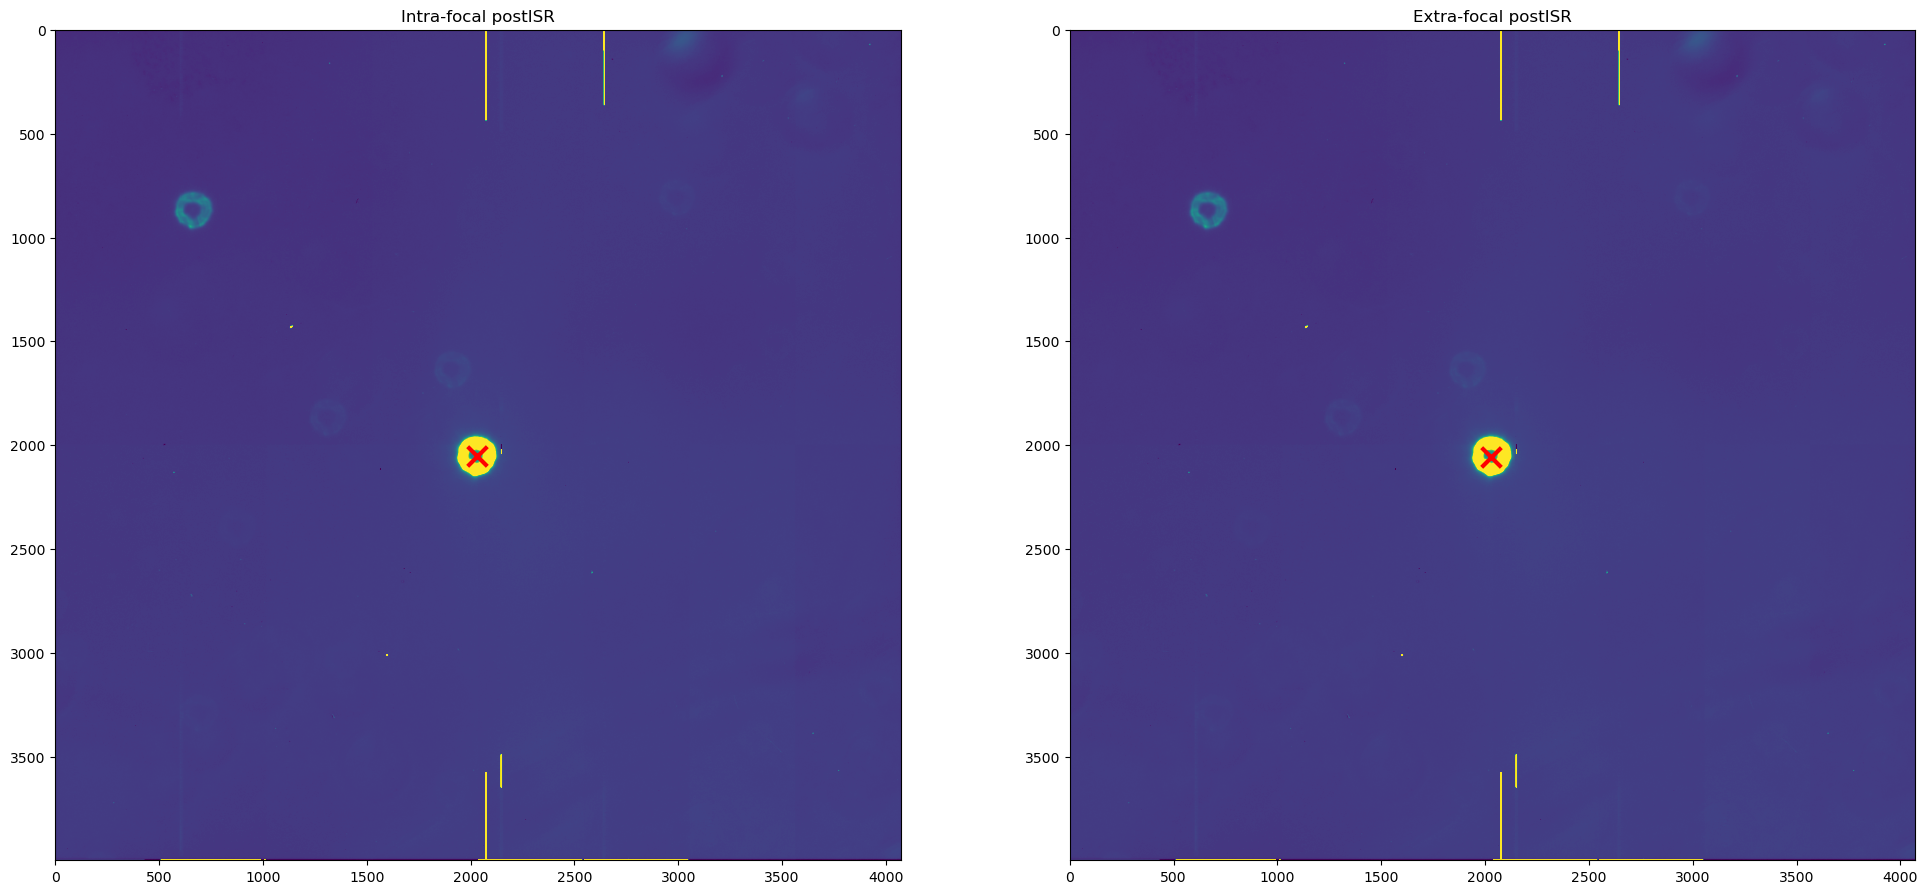

In [45]:
%matplotlib inline

fig=plt.figure(figsize=(24,12))
fig.add_subplot(1,2,1)
plt.imshow(postIsrIntra.image.array, vmin=10000, vmax=18000)
#plt.colorbar()
plt.title('Intra-focal postISR')
plt.scatter(donutCatIntra['centroid_x'], donutCatIntra['centroid_y'], c='r', marker='x', lw=3, s=200)

fig.add_subplot(1,2,2)
plt.imshow(postIsrIntra.image.array, vmin=10000, vmax=18000)
#plt.colorbar()
plt.title('Extra-focal postISR')
plt.scatter(donutCatExtra['centroid_x'], donutCatExtra['centroid_y'], c='r', marker='x', lw=3, s=200)

In [46]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [47]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=data_id_extra, collections='u/brycek/DM-37838')

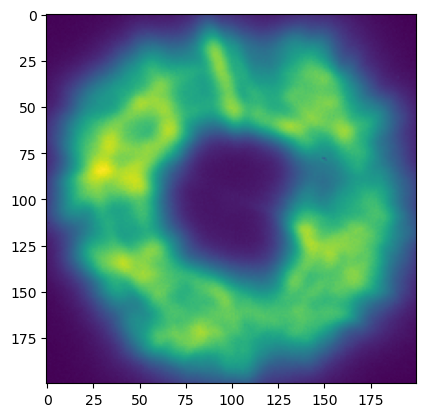

In [48]:
plt.imshow(donutStampsExtra[0].stamp_im.image.array)

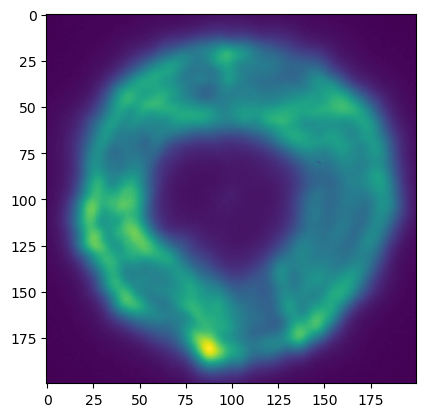

In [49]:
plt.imshow(donutStampsIntra[0].stamp_im.image.array)

In [24]:
# ! butler remove-runs /repo/embargo/ u/brycek/DM-37838 --no-confirm

The following RUN collections were removed:
u/brycek/DM-37838
The following datasets were removed:
calcZernikesTask_config(1), calcZernikesTask_log(2), calcZernikesTask_metadata(2), cutOutDonutsScienceSensorTask_config(1), cutOutDonutsScienceSensorTask_log(1), cutOutDonutsScienceSensorTask_metadata(1), donutCatalog(2), donutStampsExtra(1), donutStampsIntra(1), generateDonutDirectDetectTask_config(1), generateDonutDirectDetectTask_log(2), generateDonutDirectDetectTask_metadata(2), isr_config(1), isr_log(2), isr_metadata(2), packages(1), postISRCCD(2), zernikeEstimateAvg(1), zernikeEstimateRaw(1)
